# Regresion lineal en el Bike-sharing dataset
En este proyecto, predecirás el número de pasajeros que alquilan bicicletas.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Cargar y preparar los datos.
Un paso crítico en el trabajo en Data Science es preparar los datos correctamente. Las variables en diferentes escalas dificultan que los modelos aprendan eficientemente los pesos correctos. A continuación, escribimos el código para cargar y preparar los datos.

In [2]:
# Path al dataset.
#data_path = 'Bike-Sharing-Dataset/hour.csv'
# data_path = "https://docs.google.com/spreadsheets/d/18QoU-yVcEqxiQh_DIcoioSZCifnWZk72qaq2GCyVo_8/edit?usp=sharing"
data_path = "https://...";
# Cargar en un dataframe los datos.
rides = pd.read_csv(data_path) # pd.read_excel pd.read_hdf5

In [4]:
rides.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Verificando los datos

Este conjunto de datos tiene el número de pasajeros por cada hora de cada día desde el 1 de enero de 2011 hasta el 31 de diciembre de 2012. El número de pasajeros se divide entre casual y registrado, resumido en la columna `cnt`. Puede ver las primeras filas de los datos anteriores.

A continuación se muestra un gráfico que muestra el número de ciclistas en los primeros 10 días en el conjunto de datos. Puedes ver los alquileres por hora aquí. ¡Esta información es bastante complicada! Los fines de semana tienen un número de pasajeros más bajo y hay picos cuando las personas van en bicicleta hacia y desde el trabajo durante la semana. Al observar los datos anteriores, también tenemos información sobre la temperatura, la humedad y la velocidad del viento, lo que probablemente afecte a la cantidad de pasajeros. Intentarás capturar todo esto con tu modelo.

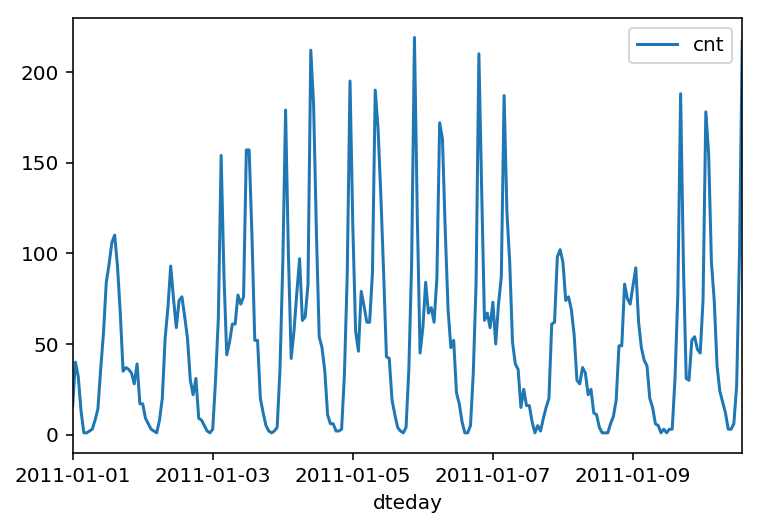

In [5]:
rides[:24*10].plot(x='dteday', y='cnt')

### Variables dummy
Aquí tenemos algunas variables categóricas como la estación, el clima y el mes. Para incluir estos en nuestro modelo, necesitaremos hacer variables ficticias binarias. Esto es simple de hacer con Pandas gracias a `get_dummies ()`.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Modelo predictivo  

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        self.activation_function = self.sigmoid
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # 5x56 56x1 = 5x1 signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) #5x1 = 5x1 signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # 1x5 5x1 = 1x1 signals into final output layer
        final_outputs = final_inputs # 1x1 signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        output_errors = targets - final_outputs #1x1 Output layer error is the difference between desired target and actual output.
        
        # TODO: Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors * 1) # 1x1 errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs) # 5x1 hidden layer gradients
        
        # BETTER TO KEEP EVERYTHING WITH THE SAME NOTATION. IN THIS WAY I CAN GENERALIZE THE EQUATION WITH FEW MODIFICATIONS
        delta_hidden = hidden_grad * np.dot(self.weights_hidden_to_output.T, output_errors) # 5x1 (5x1 1x1 = 5x1) = 5x1 
        
        # TODO: Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T) #1x1  1x5 = 1x5 update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * np.dot(delta_hidden, inputs.T) #5x1 1x56 = 5x56 update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # 5x56 56x1 = 5x1 signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # 5x1 signals from hidden layer
        
        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # 1x5 5x1 = 1x1 signals into final output layer
        final_outputs = final_inputs # 1x1 signals from final output layer 
        
        return final_outputs

In [11]:
# Costo.
def MSE(y, Y):
    return np.mean((y-Y)**2)
# Neuronas.
hidden_nodes = 25
output_nodes = 1

## EJERCICIO - Entrenando el modelo
Aquí configurarás los hiperparámetros para el modelo. La estrategia aquí es encontrar hiperparámetros tales que el error en el conjunto de entrenamiento sea bajo, pero no está sobreajustado a los datos. Si entrena la red demasiado tiempo , puede volverse demasiado específico para el conjunto de entrenamiento y no se generalizará al conjunto de validación. Es decir, la pérdida en el conjunto de validación comenzará a aumentar a medida que disminuya la pérdida del conjunto de entrenamiento.

También utilizará un método conocido como Stochastic Gradient Descent (SGD) para entrenar a la red. La idea es que para cada paso del entrenamiento, una muestra aleatoria será tomada de los datos en lugar de usar todo el conjunto de datos. Usas muchos pases de entrenamiento más que con un descenso de gradiente normal, pero cada pase es mucho más rápido. Esto termina entrenando el modelo de manera más eficiente. Aprenderá más sobre SGD más tarde.

### Elige el número de épocas
Este es el número de veces que el conjunto de datos pasará a través de la red, cada vez que actualice los pesos. A medida que aumenta el número de épocas, la red se vuelve cada vez mejor para predecir los objetivos en el conjunto de entrenamiento. Tendrá que elegir suficientes épocas para entrenar bien a la red, pero no demasiados o quedará sobreajustado.

### Elija la tasa de aprendizaje
Esto escala el tamaño de las actualizaciones de peso. Si esto es demasiado grande, los pesos tienden a explotar y la red no se ajusta a los datos. Una buena opción para comenzar es 0.1. Si el modelo tiene problemas para ajustar los datos, intente reducir la tasa de aprendizaje. Tenga en cuenta que cuanto menor es la velocidad de aprendizaje, menores son los pasos en las actualizaciones de peso y cuanto más tiempo tarda el modelo en converger.

<h3>Rangos recomendados</h3>
<ol>
    <li><strong>epochs:</strong> 100-1000</li>
    <li><strong>learning_rate:</strong> 0.001 - 0.01</li>
</ol>

In [35]:
### Ajusta tus hiperparametros con las siguientes variables ###
epochs = 1500 # ESCRIBE AQUI TU HIPERPARAMETRO
learning_rate = 0.09 # ESCRIBE AQUI TU HIPERPARAMETRO

# Mejor no modificar el siguiente codigo haha.
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)
losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    if e % 400 == 0:
        network.lr /= 2
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rEpochs: " + str(e) + " Progress: " + str(100 * e/float(epochs))[:4] \
                     + "% Training loss: " + str(train_loss)[:11] \
                     + " Validation loss: " + str(val_loss)[:11] + " Learning rate " + str(network.lr) )
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Epochs: 1499 Progress: 99.9% Training loss: 0.055050450 Validation loss: 0.131763842 Learning rate 0.005625

## Verificando tus resultados
Aquí, usamos los datos de prueba para ver qué tan bien su modelo está modelando los datos. Si algo está completamente mal aquí, vuelva a entrenar.

(0.0074724160634638617, 1.0)

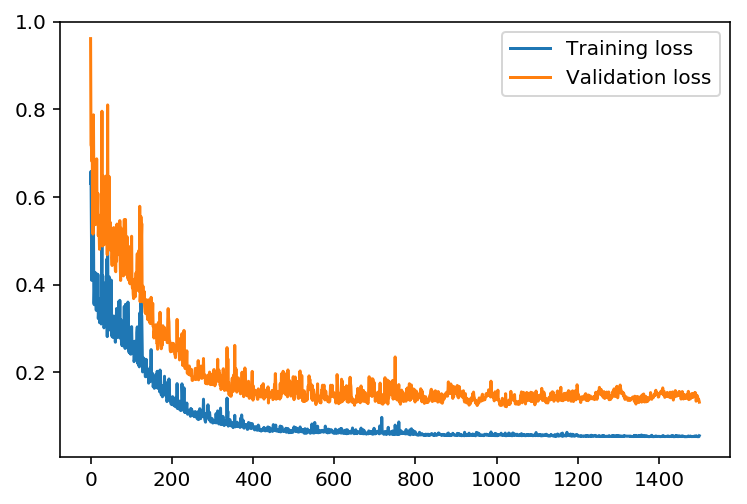

In [36]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=1.0)

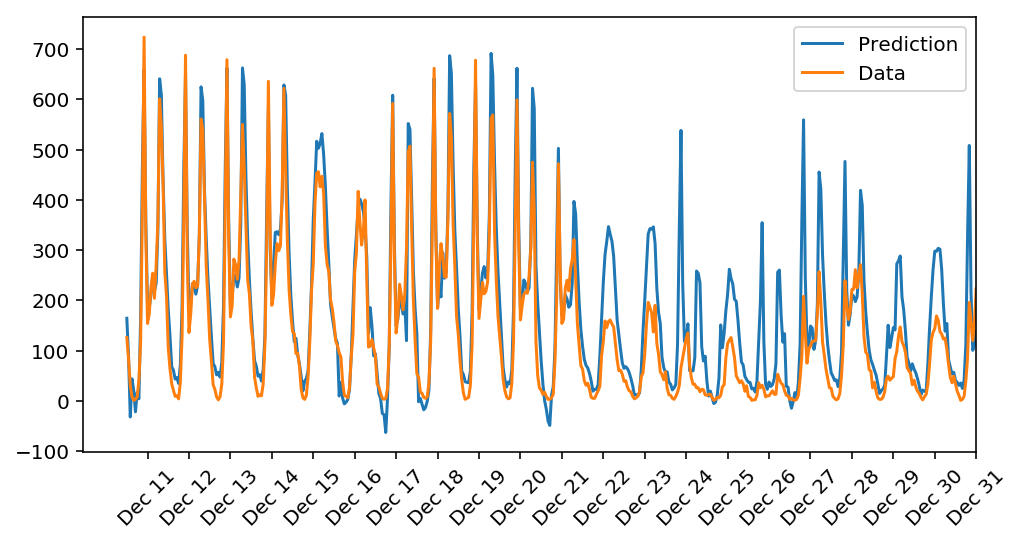

In [37]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Pensando en tus resultados
 
Responda estas preguntas sobre sus resultados. ¿Qué tan bien el modelo predice los datos? ¿Dónde falla? ¿Por qué falla donde lo hace?

#### Su respuesta a continuación
##### ¿Qué tan bien el modelo predice los datos?

##### ¿Dónde falla?

##### ¿Por qué falla donde lo hace?